In [0]:
%matplotlib inline
import pickle
from pprint import pprint
import random
import warnings
import time
# numpy, pandas, matplotlib and regular expressions (data science essentials)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# tqdm
from tqdm import tqdm
# gensim
import gensim
from gensim.models import LdaModel
from gensim import corpora
from gensim.models import CoherenceModel
# nltk
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer

In [0]:
import os 
os.chdir("/content/drive/My Drive/Colab Notebooks/Proyectos_Ley_Congreso/notebooks")

In [55]:
### cargar la data
df_total=pd.read_pickle("../data/cleaned/df_cleaned_60.pkl")
print(df_total.shape)
df_total.head()

(4617, 22)


,codigo,fechUlt,fechPres,estado,tituloProy,linkProy,periodo,legislatura,proponente,grupoParlamentario,sumilla,autores,seguimiento,inicAgrupadas,urlPdf,Archivo_Origen,Fecha,NroPaginas,Texto,Clean_Texts,Clean_Stopwords,Clean_stopword_infor
index,,,,,,,,,,,,,,,,,,,,,,
4849,04849/2019-CR,10/09/2019,09/30/2019,Decretado a...,"LEY DE REFORMA CONSTITUCIONAL, QUE ESTABLECE L...",http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,"Frente Amplio por Justicia, Vida y Libertad",Propone modificar el artículo 134 de la Const...,"[Morales Ramírez Edyson Humberto, Foronda Far...",09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484920190930.pdf,2019-09-30,11,Qº“ XCA DEL\n\nº;.\n\nm\n\n5'…»3 Ae Proyecto d...,xca del proyecto ley loncrso congreso republic...,xca proyecto ley loncrso congreso republica ar...,reforma constitucional disolucion convocatoria...
4848,04848/2019-PE,10/10/2019,09/30/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE CONCEDE LA NACIONAL...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone conceder la nacionalidad peruana a lo...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484820190930.pdf,2019-09-30,5,aT N“….ÍL.€2.LÍ PA de\n\nCONGRESO DE LA REPÚBL...,nilli congreso republica area tramite document...,nilli congreso republica area tramite document...,decenio igualdad oportunidades hombres lucha c...
4847,04847/2019-PE,10/09/2019,09/30/2019,Decretado a...,LEY QUE MODIFICA EL ARTÍCULO 8 DE LA LEY 28301...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone modificar el artículo 8 de la Ley 283...,[],09/10/2019 Decretado a... Constitución y Regl...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484720190930.pdf,2019-09-30,22,CONGRESO DE LA REPÚBLICA\nÁREA DE TRAMITE DOCU...,congreso republica area tramite documentario o...,congreso republica area tramite documentario o...,señor mesa partes pedro carlos presidente voto...
4846,04846/2019-PE,10/10/2019,09/27/2019,En comisión,RESOLUCIÓN LEGISLATIVA QUE MODIFICA EL ANEXO D...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Poder Ejecutivo,,Propone Resolución Legislativa que modifica e...,[],"04/10/2019 Decretado a... Defensa Nacional, O...",None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484620190927.pdf,2019-09-27,15,Proyecto de Resolución Legistativa N”... 731 6...,proyecto resolucion legistativa congreso repub...,proyecto resolucion legistativa congreso repub...,decenio igualdad oportunidades mujeres hombres...
4845,04845/2019-CR,10/10/2019,09/25/2019,En comisión,LEY QUE DECLARA DE INTERÉS NACIONAL Y NECESIDA...,http://www2.congreso.gob.pe/Sicr/TraDocEstProc...,Periodo de Gobierno 2016 - 2021.,Primera Legislatura Ordinaria 2019,Congreso,Contigo,Propone declarar de interés nacional y necesi...,"[Violeta López Gilbert Félix, Castro Bravo J...",04/10/2019 Decretado a... Transportes y Comun...,None,http://www.leyes.congreso.gob.pe/Documentos/20...,PL0484520190925.pdf,2019-09-25,7,....... CONGRESO DE LA REPÚBLICA\nPÍO)'€CÍO d€...,congreso republica piocio ley ecco ouc sep pro...,congreso republica piocio ley ecco ouc sep pro...,ampliacion mejoramiento asfalto carretera pasa...


In [41]:
### train test split
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df_total[["Clean_stopword_infor"]],test_size=0.2)
print(df_train.shape,df_test.shape)

(3693, 1) (924, 1)


In [0]:
df_train.to_pickle("../models/topic_modelling/df_train.pkl")
df_test.to_pickle("../models/topic_modelling/df_test.pkl")

In [0]:
### crear diccionario y el corpus para aplicar bag of words
text_data=[i.split() for i in df_train["Clean_stopword_infor"]]
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [0]:
pickle.dump( dictionary, open( "../models/topic_modelling/dictionary.pkl", "wb" ) )
# pickle.dump( corpus, open( "../models/topic_modelling/corpus.pkl", "wb" ) )

In [0]:
### entrenamiento modelos lda
no_of_topics=[i for i in range(5,105,5)]
for i in no_of_topics:
  NUM_TOPICS = i
  start_time = time.time()
  ldamodel = LdaModel(corpus, 
                      num_topics=NUM_TOPICS, 
                      random_state=89, 
                      update_every=1,  
                      id2word=dictionary, 
                      passes=42, 
                      alpha='auto', 
                      per_word_topics=True)
  pickle.dump( ldamodel, open( "../models/topic_modelling/lda_models/model_{}.pkl".format(NUM_TOPICS), "wb" ) )

In [0]:
### Evaluacion de los modelos lda
list_coherence=[]
for i in no_of_topics:
  ldamodel=pickle.load(open("../models/topic_modelling/lda_models/model_{}.pkl".format(i), "rb" ))
  coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  list_coherence.append(coherence_lda)

In [0]:
np.save("../models/topic_modelling/list_coherence.npy",list_coherence)

In [47]:
data={"Number of Topics":no_of_topics,
 "Coherence Scores":list_coherence}
pd.DataFrame(data)

,Number of Topics,Coherence Scores
0,5,0.466431
1,10,0.563457
2,15,0.605703
3,20,0.639432
4,25,0.630456
5,30,0.636797
6,35,0.665184
7,40,0.663560
8,45,0.654400
9,50,0.659990


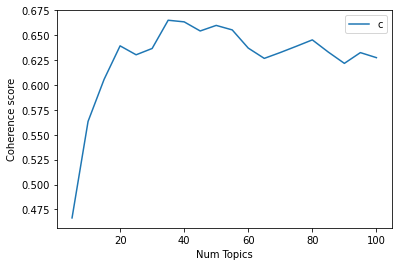

In [48]:
### mostrar gráfico de rendimiento de los modelos lda
coherence_scores = list_coherence
plt.plot(no_of_topics, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
### Se logra un mejor performance con 35 topicos
ldamodel=pickle.load(open("../models/topic_modelling/lda_models/model_{}.pkl".format(35), "rb" ))

In [60]:
### Visualizar las palabras relacionadas a ciertos topicos
print("Allocated models of each topic...")
topics_train = []
topics = ldamodel.print_topics(num_topics=35)
for topic in topics:
    pprint(topic)
    topics_train.append(topic)

Allocated models of each topic...
(0,
 '0.053*"personal" + 0.045*"policia" + 0.027*"decreto" + 0.025*"fuerzas" + '
 '0.024*"policial" + 0.024*"armadas" + 0.021*"militar" + 0.021*"defensa" + '
 '0.018*"legislativo" + 0.015*"seguridad"')
(1,
 '0.042*"transporte" + 0.019*"vehiculos" + 0.018*"gas" + 0.018*"transito" + '
 '0.011*"seguridad" + 0.010*"uso" + 0.010*"natural" + 0.009*"accidentes" + '
 '0.008*"transportes" + 0.008*"terrestre"')
(2,
 '0.047*"consejo" + 0.037*"colegio" + 0.026*"directivo" + 0.020*"decana" + '
 '0.015*"palabra" + 0.014*"pide" + 0.013*"animales" + 0.012*"sesion" + '
 '0.010*"maria" + 0.010*"email"')
(3,
 '0.037*"justicia" + 0.034*"judicial" + 0.021*"consejo" + '
 '0.015*"constitucional" + 0.015*"fiscales" + 0.014*"junta" + 0.014*"jueces" + '
 '0.013*"miembros" + 0.012*"corte" + 0.012*"magistratura"')
(4,
 '0.032*"san" + 0.027*"regional" + 0.023*"departamento" + 0.022*"canon" + '
 '0.022*"provincia" + 0.020*"region" + 0.019*"callao" + 0.017*"loreto" + '
 '0.013*"piur

In [0]:
### etiquetar los topicos en base a la palabras relacionado a un cierto topico
names_topic={
    0:"Policia Militar",1:"Transporte",2:"Decana",3:"Justicia",4:"Canon Departamentos",5:"Salud",6:"Concientizacion Ambiental",7:"Inversion Publica",8:"TelefonoAnexo",
    9:"Elecciones del extranjero",10:"Educacion",11:"Proteccion Ambiental",12:"Demarcacion Territorial",13:"Relaciones Exteriores",14:"Agua Potable",15:"Mineria",
    16:"Innovacion Tecnologica",17:"Impuestos Tributarios",18:"Legislacion",19:"Seguridad de Pensiones",20:"Reduccion de Pobreza",21:"Presupuesto",22:"Regulacion del Mercado",
    23:"Territorio Nacional",24:"Pueblos Indigenas",25:"Gobiernos Regionales",26:"Igualdad de Genero",27:"Productores Agricolas",28:"Turismo Construccion",29:"Procesos Penales",
    30:"Elecciones Generales",31:"Incentivacion de Lectura",32:"Patrimonio Cultural",33:"Control de Corrupcion",34:"Derecho del niño"
}

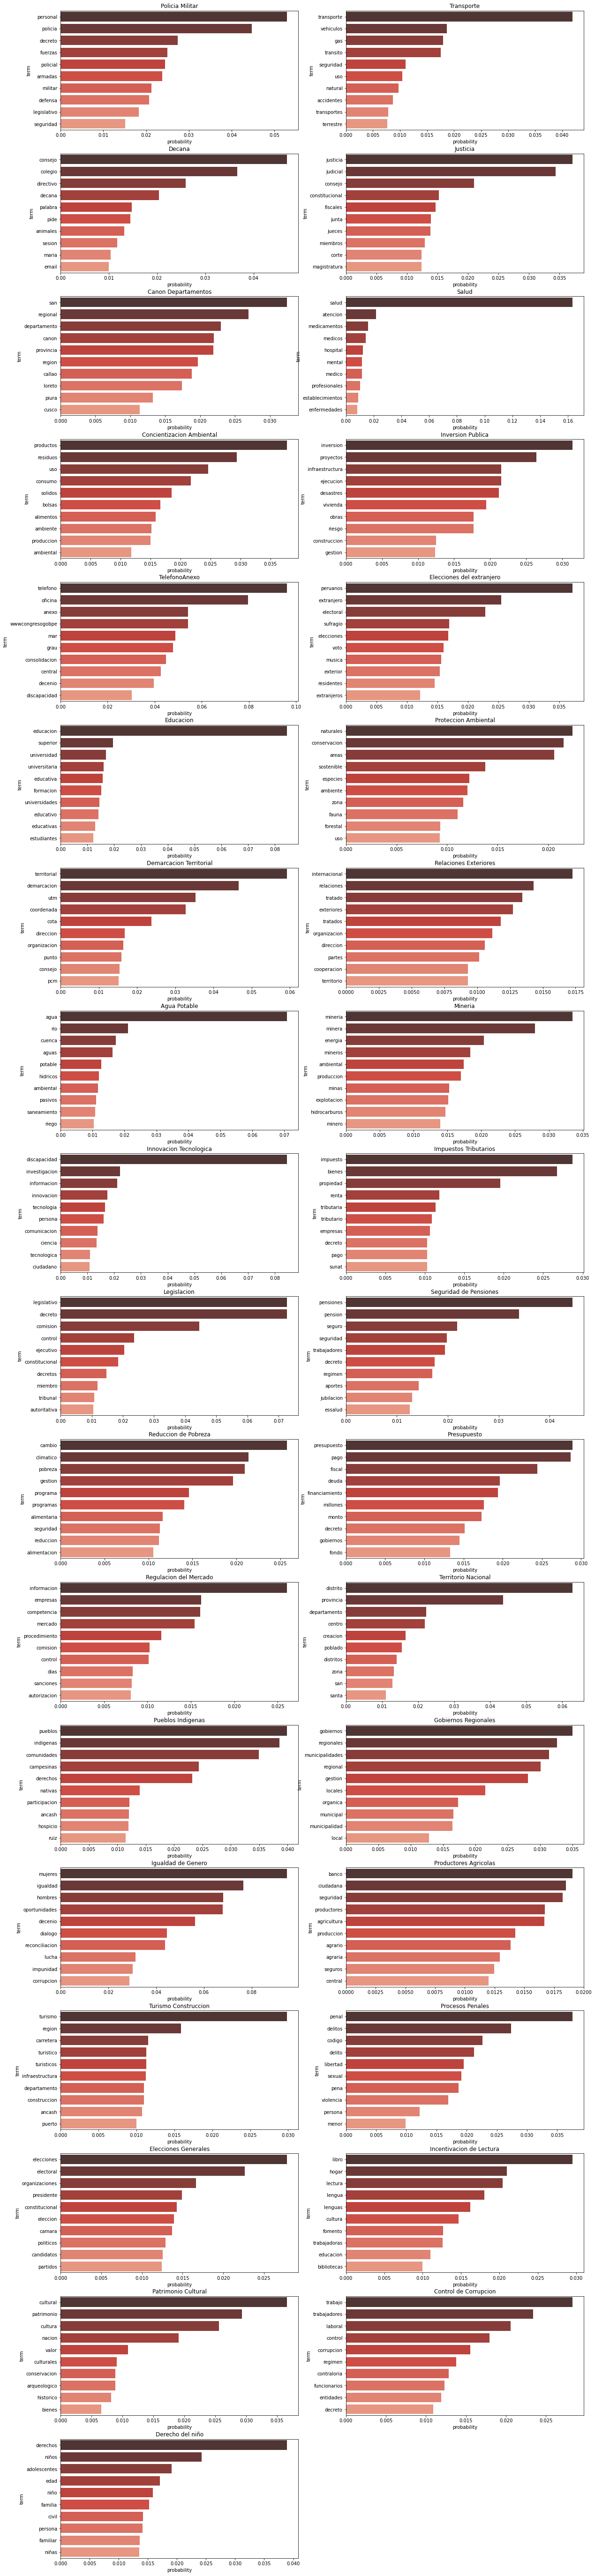

In [62]:
### Visualizando los topicos
fig = plt.figure(figsize=(20,100))
for n,i in zip(list(names_topic.values()),range(35)):
    df = pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
    ax=fig.add_subplot(18,2,i+1)
    ax.set_title(n)
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    ax.set_xlabel('probability')
plt.show()

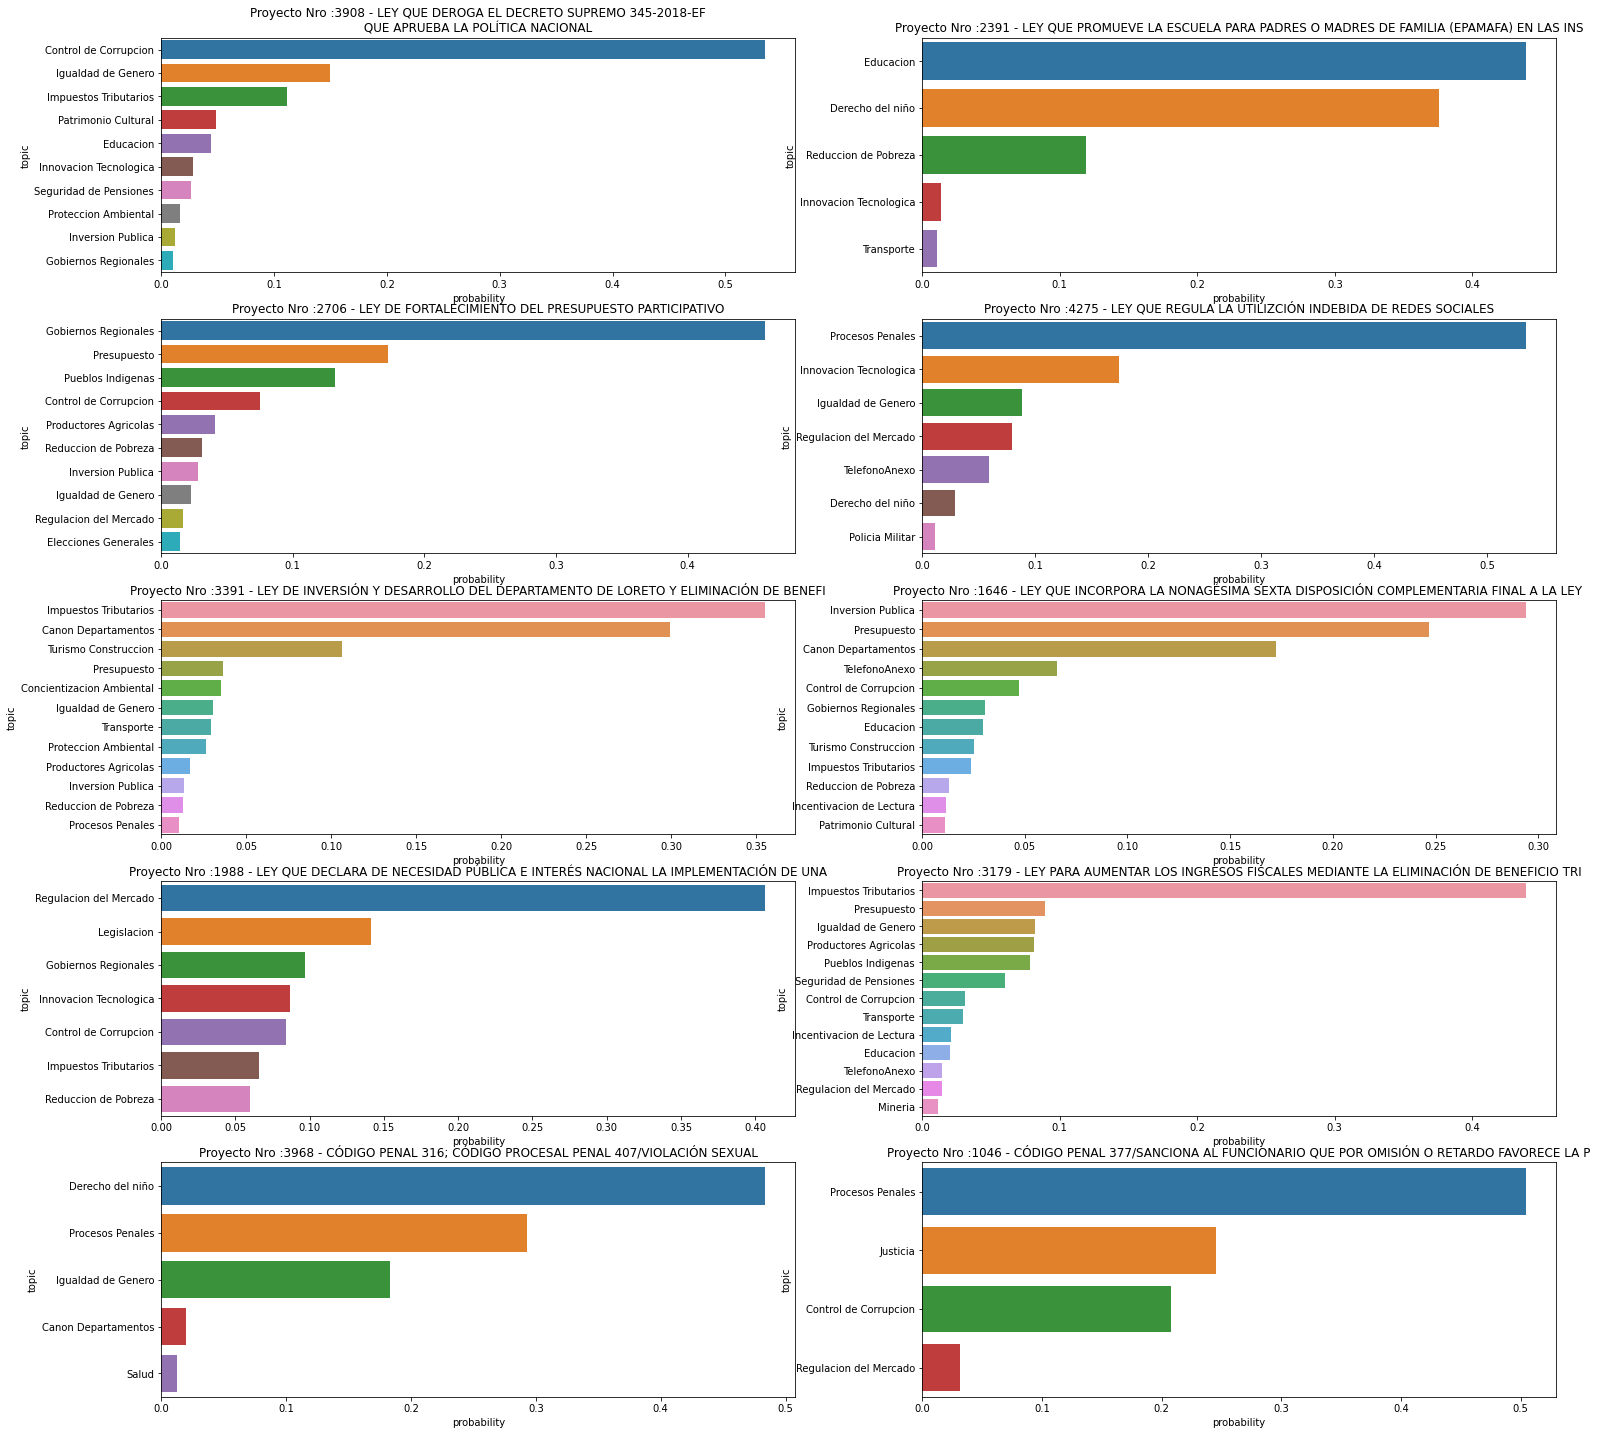

In [66]:
### Visualizando los tópicos de cada proyecto de ley

# proyecto 4836,4838,4939, 4842(***), 4845, 4849
text=[ i.split() for i in  df_test["Clean_stopword_infor"]][0:10]
index=[ i for i in  df_test["Clean_stopword_infor"].index][0:10]
fig = plt.figure(figsize=(25,25))
for n,(i,ind) in enumerate(zip(text,index)):
  i_bow=dictionary.doc2bow(i)
  df = pd.DataFrame(ldamodel.get_document_topics(i_bow), columns=['topic','probability'])
  df.replace({"topic": names_topic},inplace=True)
  df=df.set_index('topic')
  df.sort_values("probability",ascending=False,inplace=True)
  ax=fig.add_subplot(5,2,n+1)
  title=df_total.loc[str(ind),:]["tituloProy"].replace(",","\n")[0:80]
  ax.set_title('Proyecto Nro :{} - {}'.format(ind,title))
  sns.barplot(x='probability', y=df.index, data=df)
plt.show()